In [2]:
from cv2 import imread, imwrite, cvtColor, COLOR_BGR2RGB, COLOR_RGB2BGR, COLOR_RGB2GRAY, COLOR_GRAY2RGB, CV_32F, \
                resize, getRotationMatrix2D, warpAffine, flip, GaussianBlur, equalizeHist, Sobel, filter2D
from numpy import sin, cos, radians, sqrt, arctan, pi, zeros, ones, clip, uint8, array
from matplotlib.pyplot import figure, subplot, imshow, show, title
from numba import jit
from os.path import join
from os import getcwd
from time import strftime

In [3]:
imgName = input('請輸入影像檔名(含副檔名)：')
IMAGES_DIR = join(getcwd(), 'images', imgName)
imgSrc = cvtColor(imread(IMAGES_DIR), COLOR_BGR2RGB)

def imgCheck(source, result, gray = 0):
    figure(figsize = (15, 10))
    subplot(121)
    title('Original Image')
    imshow(source)
    subplot(122)
    title('Processed Image')
    if gray == 0:
        imshow(result)
    else:
        imshow(result, 'gray')
    show()
    
def errorMessage():
    print('\n輸入錯誤，請重新輸入\n')
    
@jit
def imgDistortion(source, result, k):
    imgRow, imgCol = source.shape[:2]
    x0, y0 = int(imgRow / 2), int(imgCol / 2)
    rMax = sqrt(x0 ** 2 + y0 ** 2)
    
    for r in range(imgRow):
        for c in range(imgCol):
            same = 0
            rd = sqrt((r - x0) ** 2 + (c - y0) ** 2)
            ru = rd + k * ((rd / rMax) ** 2)
            
            if r == x0:
                if c > y0:
                    angle = radians(90)
                elif c < y0:
                    angle = radians(270)
                else:
                    same = 1
                    for color in range(3):
                        result[r, c, color] = source[x0, y0, color]
            else:
                angle = arctan((c - y0) / (r - x0))
                angle += pi if (r < x0) else 0
                
            if same == 0:
                x, y = x0 + ru * cos(angle), y0 + ru * sin(angle)
                int_x, int_y = int(x), int(y)
                u, v = x - int_x, y - int_y
        
                if 0 <= int_x < imgRow and 0 <= int_y < imgCol:
                    for color in range(3):
                        result[r, c, color] = (1 - u) * (1 - v) * source[int_x, int_y, color] + (1 - u) * v * \
                        source[int_x, int_y + 1, color]+ u * (1 - v) * source[int_x + 1, int_y, color] + u * v * \
                        source[int_x + 1, int_y + 1, color]
    return result

請輸入影像檔名(含副檔名)：Atlantis.jpg


請輸入想進行的處理 (1)影像幾何轉換、(2)亮度調整、(3)影像濾波、(4)結束：1
請選擇功能 (1)影像縮放、(2)影像旋轉、(3)影像翻轉、(4)失真調整、(5)儲存變更並返回、(6)不儲存變更並返回：2
請輸入旋轉角度：-20


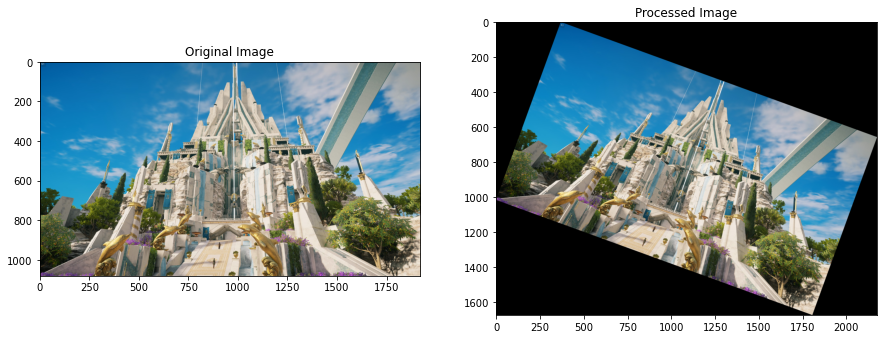

請選擇功能 (1)影像縮放、(2)影像旋轉、(3)影像翻轉、(4)失真調整、(5)儲存變更並返回、(6)不儲存變更並返回：4
請輸入失真係數 (大於零為桶型失真，小於零為枕形失真)：50


In [ ]:
imgTemp = imgSrc.copy(); imgResult = imgSrc.copy()
imgRow, imgCol = imgSrc.shape[:2]

while(True):
    choice = input('請輸入想進行的處理 (1)影像幾何轉換、(2)亮度調整、(3)影像濾波、(4)結束：')
    if choice == '1':
        while(True):
            choice = input('請選擇功能 (1)影像縮放、(2)影像旋轉、(3)影像翻轉、(4)失真調整、(5)儲存變更並返回、(6)不儲存變更並返回：')
            if choice == '1':
                size = float(input('請輸入縮放大小：'))
                imgResult = resize(imgResult, (int(imgCol * size), int(imgRow * size)))
                imgRow, imgCol = imgResult.shape[:2]
                imgCheck(imgSrc, imgResult)
            elif choice == '2':
                angle = float(input('請輸入旋轉角度：'))
                rotationMatrix = getRotationMatrix2D((imgCol / 2, imgRow / 2), angle, 1)
                imgRow_new = int(imgCol * abs(sin(radians(angle))) + imgRow * abs(cos(radians(angle))))
                imgCol_new = int(imgRow * abs(sin(radians(angle))) + imgCol * abs(cos(radians(angle)))) 
                rotationMatrix[0, 2] += (imgCol_new - imgCol) / 2
                rotationMatrix[1, 2] += (imgRow_new - imgRow) / 2
                imgResult = warpAffine(imgResult, rotationMatrix, (imgCol_new, imgRow_new))
                imgRow, imgCol = imgResult.shape[:2]
                imgCheck(imgSrc, imgResult)
            elif choice == '3':
                while(True):
                    flipCode = int(input('請輸入翻轉方式 (0)上下翻轉、(1)左右翻轉：'))
                    if flipCode in [0, 1]:
                        imgResult = flip(imgResult, flipCode)
                        imgCheck(imgSrc, imgResult)
                        break
                    else:
                        errorMessage()
            elif choice == '4':
                correction = int(input('請輸入失真係數 (大於零為桶型失真，小於零為枕形失真)：'))
                imgBlank = zeros((imgRow, imgCol, 3), dtype = uint8)
                imgResult = imgDistortion(imgResult, imgBlank, correction)
                imgCheck(imgSrc, imgResult)
            elif choice == '5':
                imgTemp = imgResult.copy()
                break
            elif choice == '6':
                imgRow, imgCol = imgTemp.shape[:2]
                imgResult = imgTemp.copy()
                imgCheck(imgSrc, imgResult)
                break
            else:
                errorMessage()
    elif choice == '2':
        while(True):
            choice = input('請選擇功能 (1)手動調整亮度、(2)自動調整至合適亮度、(3)儲存變更並返回、(4)不儲存變更並返回：')
            if choice == '1':
                lumen = float(input('請輸入亮度調整量：'))
                for color in range(3):
                    imgResult[:, :, color] = uint8(clip(imgResult[:, :, color] * abs(lumen), 0, 255))
                imgCheck(imgSrc, imgResult)
            elif choice == '2':
                for color in range(3):
                    imgResult[:, :, color] = equalizeHist(imgResult[:, :, color])
                imgCheck(imgSrc, imgResult)
            elif choice == '3':
                imgTemp = imgResult.copy()
                break
            elif choice == '4':
                imgResult = imgTemp.copy()
                imgCheck(imgSrc, imgResult)
                break
            else:
                errorMessage()          
    elif choice == '3':
        while(True):
            choice = input('請選擇功能 (1)影像模糊化與雜訊消除、(2)影像邊緣顯示、(3)影像銳化(黑白)、(4)儲存變更並返回、(5)不儲存變更並返回：')
            if choice == '1':
                while(True):
                    maskSize = input('請輸入遮罩大小 (數值越大越模糊，以小寫x為間隔輸入兩個相同的奇數，例如：5x5)：')
                    maskSize = maskSize.split('x')
                    if len(maskSize) == 2:
                        if len(set(maskSize)) == 1:
                            if int(maskSize[0]) % 2 == 1:
                                maskSize = tuple([abs(int(i)) for i in maskSize])
                                imgResult = GaussianBlur(imgResult, maskSize, 0)
                                imgCheck(imgSrc, imgResult)
                                break
                            else:
                                errorMessage()
                        else:
                            errorMessage()
                    else:
                        errorMessage()
            elif choice == '2':
                imgResult = cvtColor(imgResult, COLOR_RGB2GRAY)
                imgResult = Sobel(imgResult, CV_32F, 1, 1)
                imgResult = uint8(clip(imgResult, 0, 255))
                imgResult = cvtColor(imgResult, COLOR_GRAY2RGB)
                imgCheck(imgSrc, imgResult, 1)
            elif choice == '3':
                imgResult = cvtColor(imgResult, COLOR_RGB2GRAY)
                mask = array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
                imgResult = filter2D(imgResult, CV_32F, mask)
                imgResult = uint8(clip(imgResult, 0, 255))
                imgResult = cvtColor(imgResult, COLOR_GRAY2RGB)
                imgCheck(imgSrc, imgResult, 1)
            elif choice == '4':
                imgTemp = imgResult.copy()
                break
            elif choice == '5':
                imgResult = imgTemp.copy()
                imgCheck(imgSrc, imgResult)
                break
            else:
                errorMessage()
    elif choice == '4':
        exit = 0
        while(True):
            choice = input('是否要保存圖片？(Y)是、(N)否、(R)返回：')
            if choice in ['Y', 'y']:
                fileName = strftime('image_processed_%y%m%d_%H%M%S.jpg')
                imwrite(fileName, cvtColor(imgResult, COLOR_RGB2BGR))
                print('檔案已存檔，檔名為：{}'.format(fileName))
                exit = 1
                break
            elif choice in ['N', 'n']:
                exit = 1
                break
            elif choice in ['R', 'r']:
                break
            else:
                errorMessage()
        if exit == 1:
            break
    else:
        errorMessage()